In [2]:
import numpy as np
from scipy.special import erf, erfc
from scipy.optimize import root, curve_fit
import matplotlib.pyplot as plt
import re

plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 14

In [3]:
Tm      = 54.        # *C
Tw      = 120.        # *C
T1      = 30.        # *C
L       = 2.1e5      # J/kg
rho_l   = 780.       # kg/m^3
rho_s   = 860.       # kg/m^3
lam_l   = 0.15       # W/K m
lam_s   = 0.24       # W/K m
c_l     = 2100.      # J/kg K
c_s     = 2900.      # J/kg K

a_s = lam_s / (rho_s * c_s)
a_l = lam_l / (rho_l * c_l)

### Analytisch k

(np.float64(0.4081365927393771), np.float64(-2.220446049250313e-16))

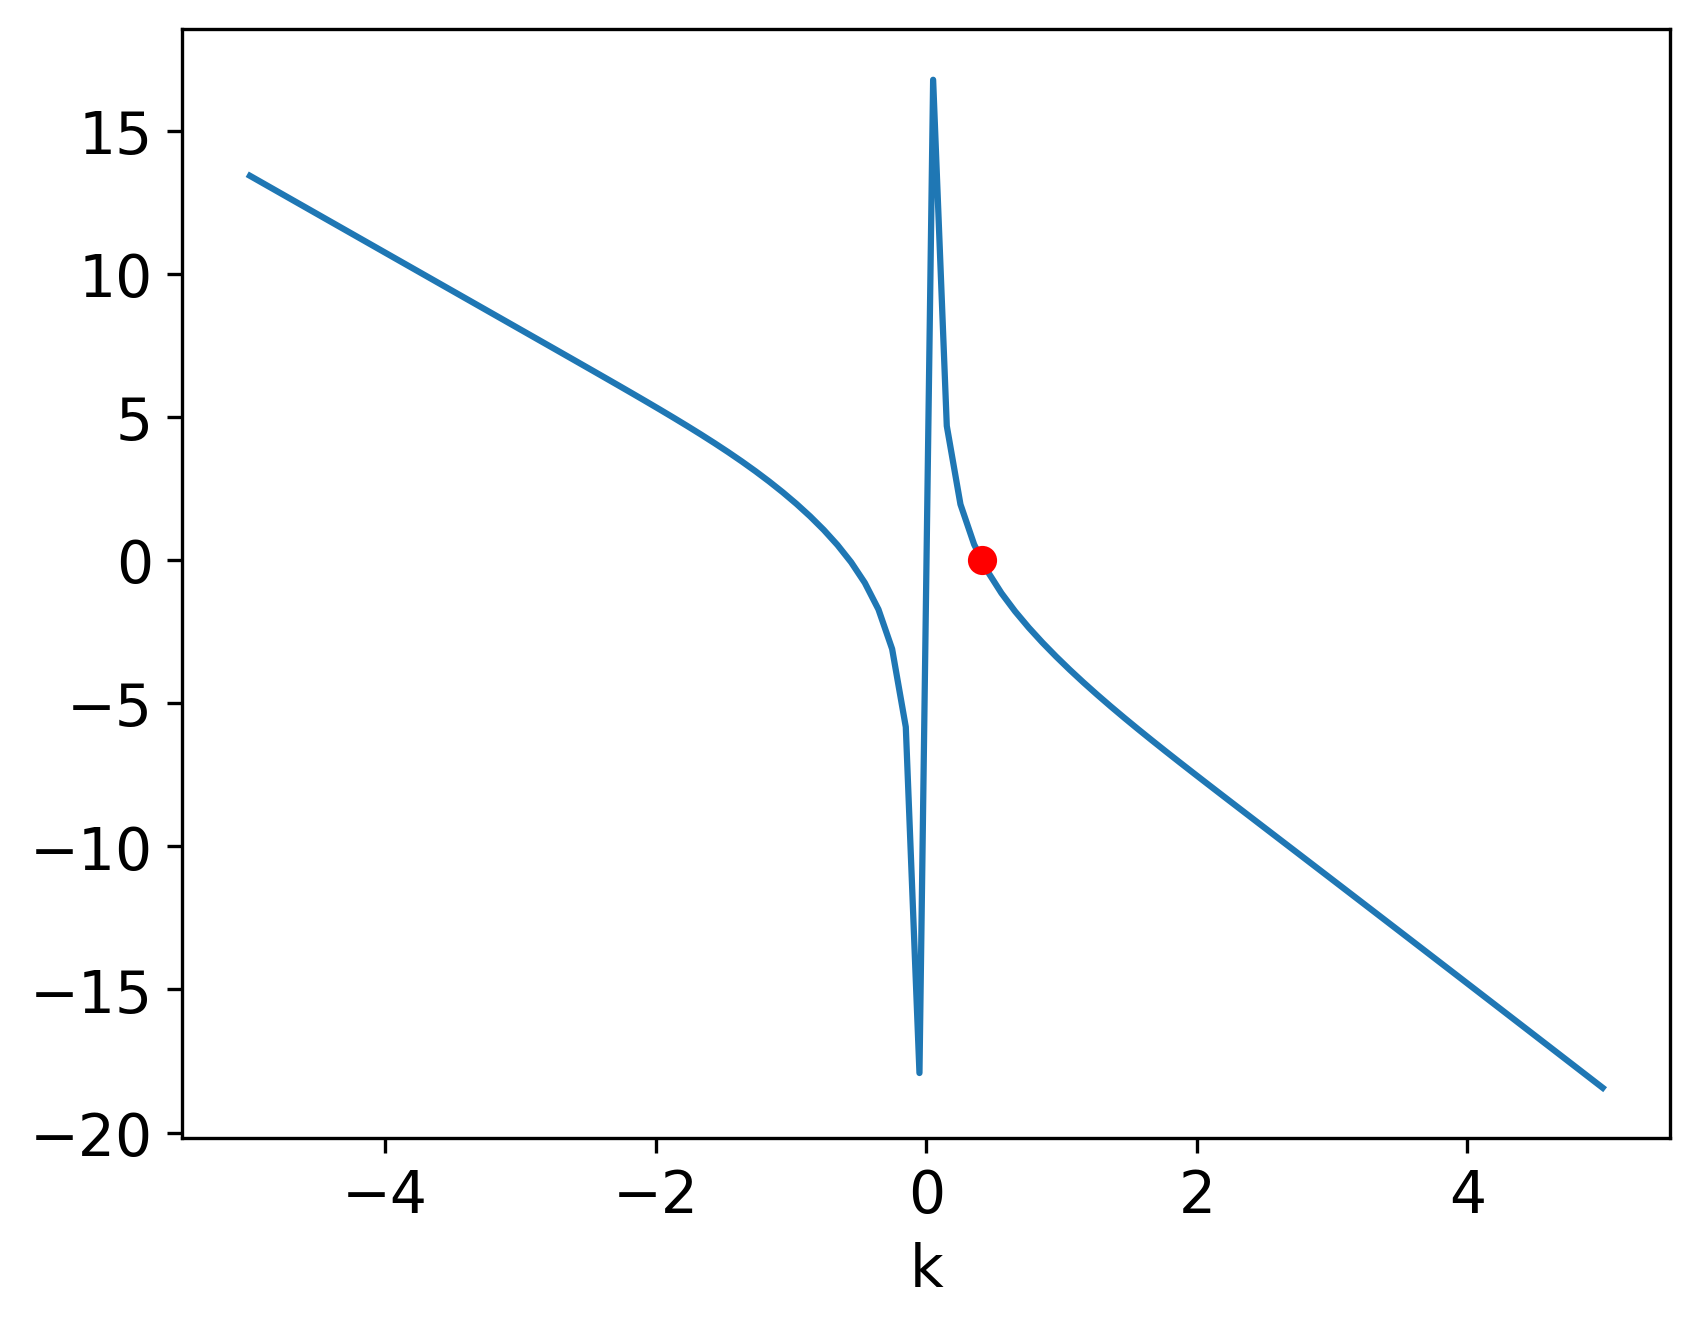

In [4]:
root_function = lambda k: np.exp(-k**2) / erf(k) \
    + lam_s / lam_l * np.sqrt(a_l / a_s) * (T1 - Tm) / (Tw - Tm) * np.exp(-k**2 * (a_l / a_s)) / erfc(k * np.sqrt(a_l / a_s)) \
    - k * L * np.sqrt(np.pi) / c_l / (Tw - Tm)

ki = np.linspace(-5, 5, 100)
k = root(root_function, 2)["x"][0]

plt.plot(ki, root_function(ki))
plt.plot(k, root_function(k), 'ro')
plt.xlabel("k")
k, root_function(k)

In [5]:
def open_sim_file(filename):
    pattern = r"dT=([0-9.eE+-]+),dx=([0-9.eE+-]+),dt=([0-9.eE+-]+)"

    T = np.loadtxt(filename, delimiter=',')

    match = re.search(pattern, filename)
    if match:
        dT = float(match.group(1))
        dx = float(match.group(2))
        dt = float(match.group(3)[:-1] if match.group(3)[-1] == '.' else match.group(3))
        return T, dT, dx, dt
    else:
        raise "Incorrect filename"

In [6]:
w = 50e-3
t1 = 3600. # simulation time to run for
fps = 1 # fps for animation

Text(0, 0.5, '# (-)')

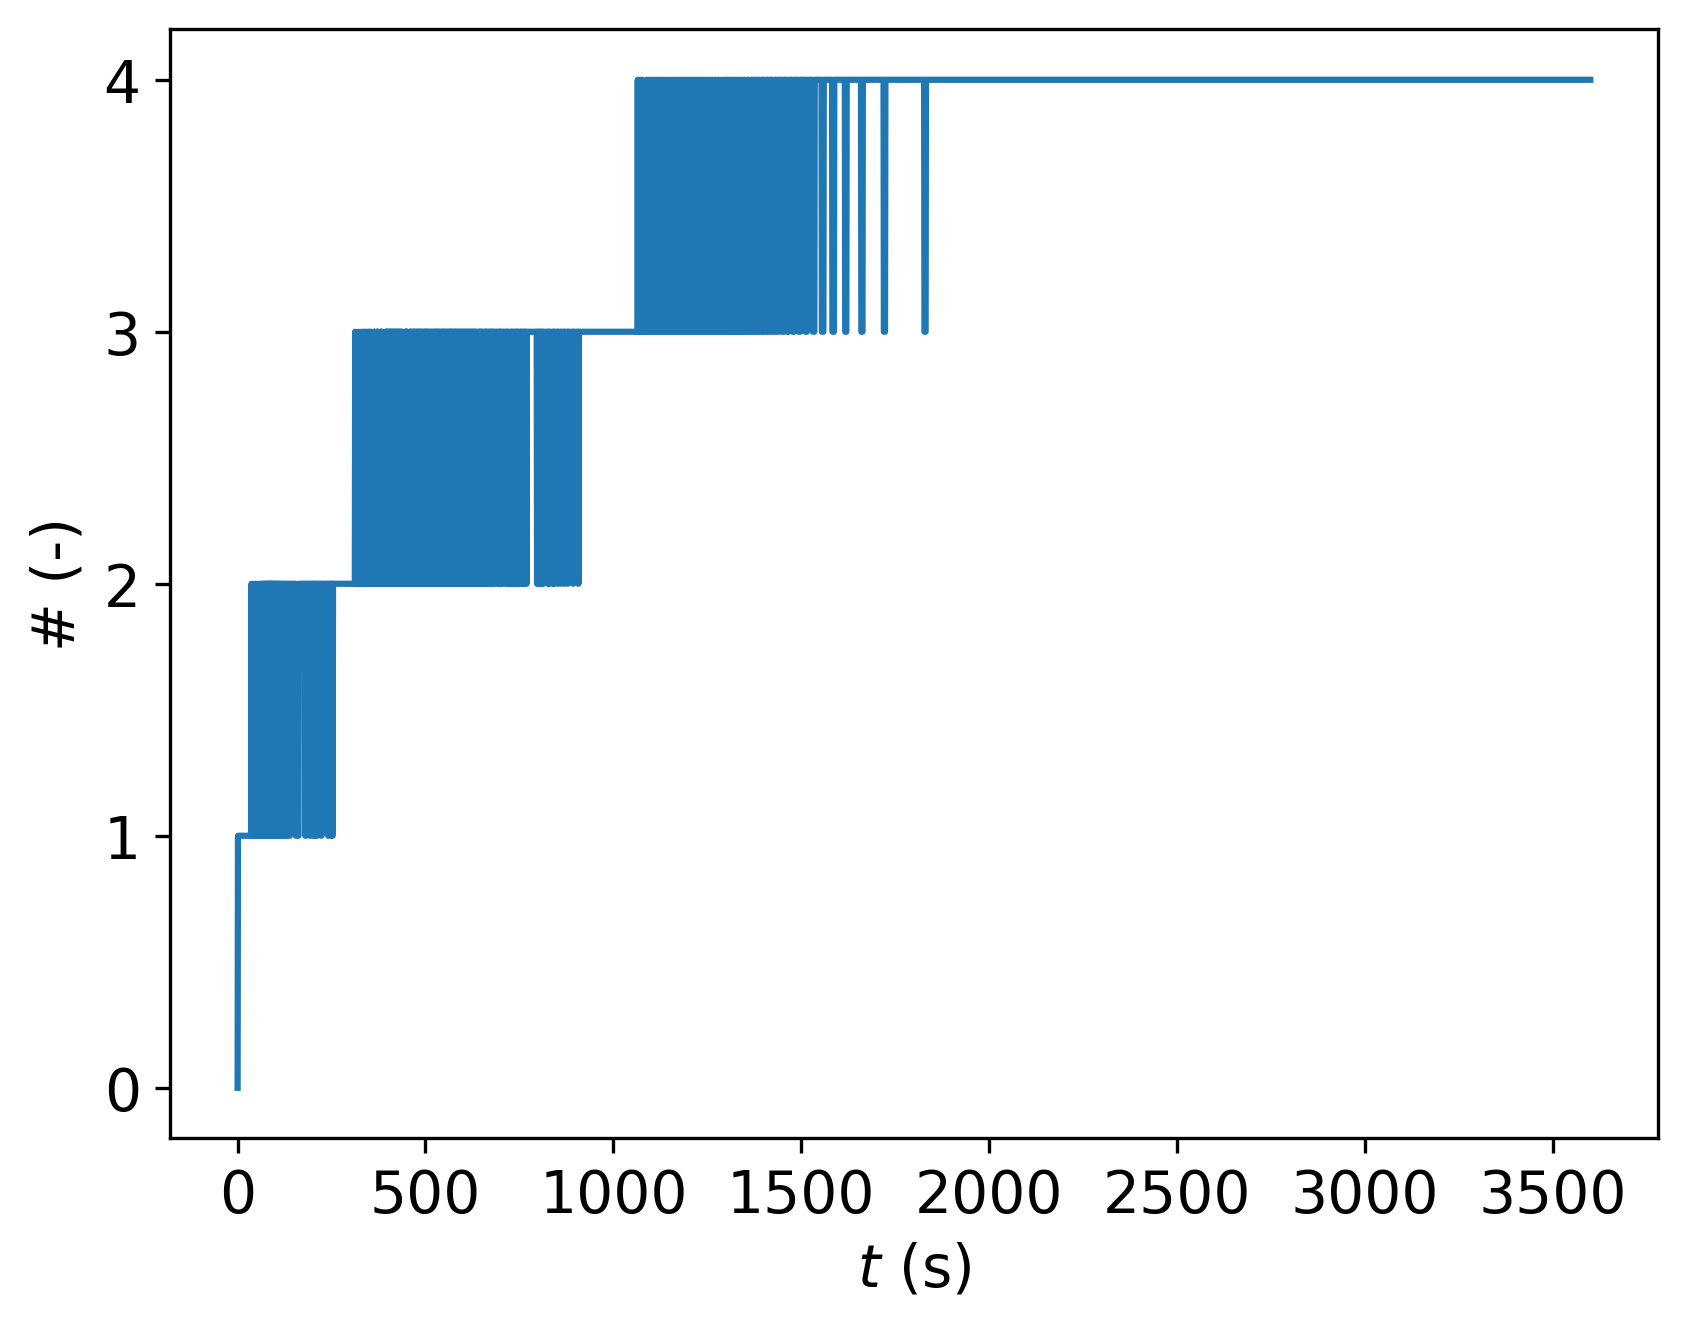

In [7]:
dT = 0.05
T, dT, dx, dt = open_sim_file("results,T0=120.0,dT=0.05,dx=1.0e-05,dt=1.0e-05.csv")

x = np.arange(0, w, dx) # all cell positions
N = int(t1 / dt) # number of iterations for simulation time

t_fps = 1 / fps / dt # number of iterations between each frame
frames = np.where(np.arange(N, dtype=int) % int(t_fps) == 0)[0] # all iterations that are displayed

mushy_count = []

for i in range(len(T)):
    mushy_count.append(sum((Tm - dT < T[i]) & (T[i] < Tm + dT)))

t = frames * dt
plt.plot(t, mushy_count)
plt.yticks(np.arange(max(mushy_count) + 1))
plt.xlabel("$t$ (s)")
plt.ylabel("# (-)")

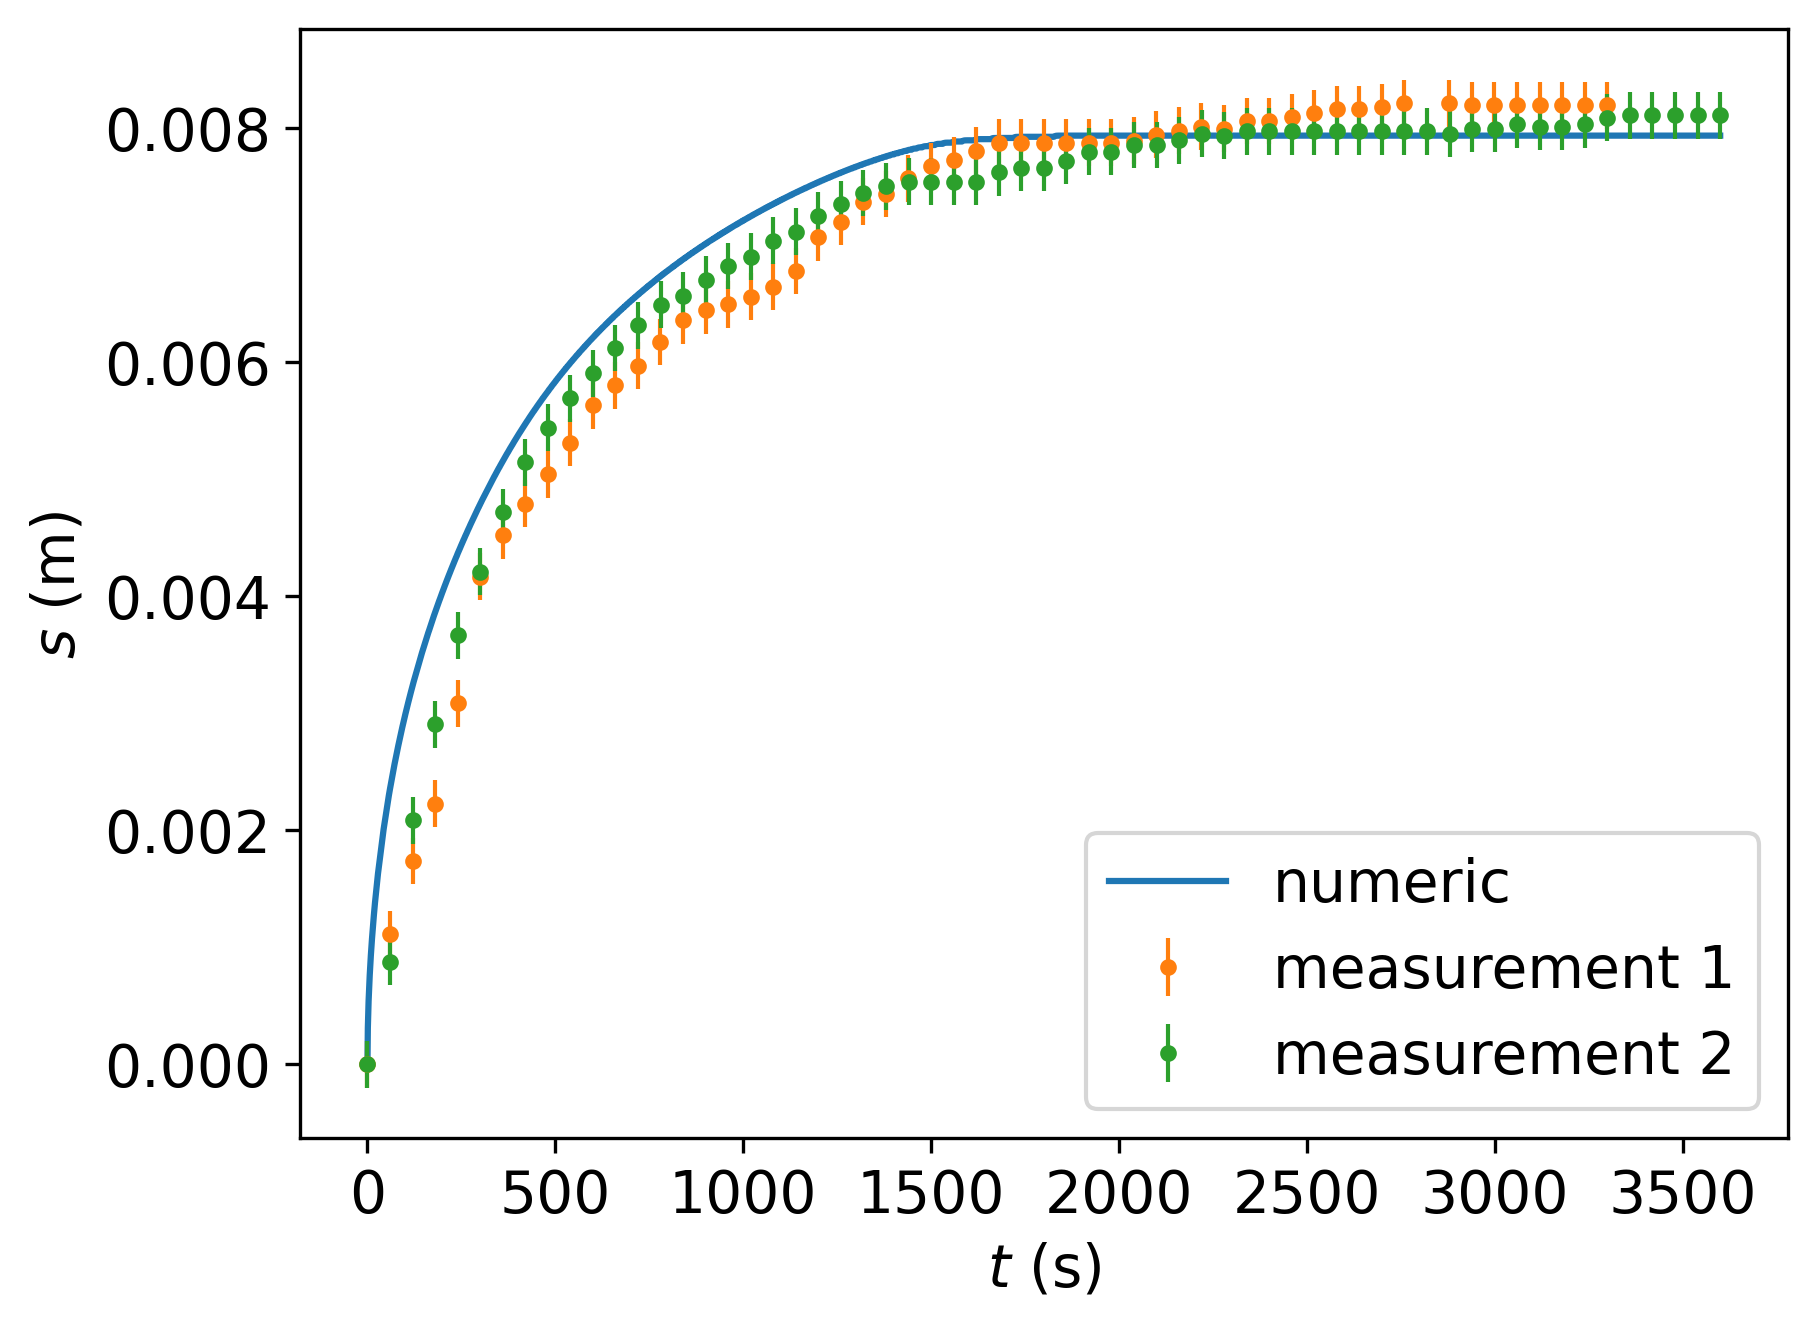

In [8]:
# T = np.loadtxt("returnsT0=120.0,dT=0.5,dx=4,dt=4_lossless.csv", delimiter=',')

T, dT, dx, dt = open_sim_file("results,T0=120.0,dT=0.05,dx=1.0e-05,dt=1.0e-05.csv")
x = np.arange(0, w, dx) # all cell positions
N = int(t1 / dt) # number of iterations for simulation time

fps = 1
t_fps = 1 / fps / dt # number of iterations between each frame
frames = np.where(np.arange(N, dtype=int) % int(t_fps) == 0)[0] # all iterations that are displayed


_, t_exp1, s_exp1 = np.loadtxt("VID2_20250702_121653112.csv", delimiter=',', skiprows=1).T
_, t_exp2, s_exp2 = np.loadtxt("VID2_20250702_141248613.csv", delimiter=',', skiprows=1).T

s_exp1 /= 1e3
s_exp2 /= 1e3

s = [x[np.abs(T[0] - Tm).argmin()]]
for i in range(1, len(frames)):
    index_min = np.abs(T[i] - Tm).argmin()
    if T[i][index_min] > Tm:
        s.append(x[index_min] + (Tm - T[i][index_min]) / (T[i][index_min + 1] - T[i][index_min]) * dx)
    if T[i][index_min] < Tm:
        s.append(x[index_min] - (Tm - T[i][index_min]) / (T[i][index_min - 1] - T[i][index_min]) * dx)

# s = [x[np.abs(T[i] - Tm).argmin()] for i in range(len(frames))]
t = frames * dt

plt.plot(t, s, label="numeric")
plt.errorbar(t_exp1[t_exp1 < t1 + min(t_exp1)] - min(t_exp1), s_exp1[t_exp1 < t1 + min(t_exp1)], yerr=0.0002, elinewidth=1, fmt='.', label="measurement 1")
plt.errorbar(t_exp2[t_exp2 < t1 + min(t_exp2)] - min(t_exp2), s_exp2[t_exp2 < t1 + min(t_exp2)], yerr=0.0002, elinewidth=1, fmt='.', label="measurement 2")
# plt.plot(t, 2 * k * np.sqrt(a_l * t), label="analytic")
plt.xlabel("$t$ (s)")
plt.ylabel("$s$ (m)")
plt.legend(loc="lower right")

simulation:	x_max = 0.008052727024865456 +/- 2.625745762962267e-06	tau = 642.0378379409382 +/- 1.4148458600652665
result 1:	x_max = 0.008675732989282084 +/- 0.00011204764287227913	tau = 1169.4952141071935 +/- 66.6807313259528
result 2:	x_max = 0.008214730793234743 +/- 3.9635300359545736e-05	tau = 878.4557430266236 +/- 27.453949004471877


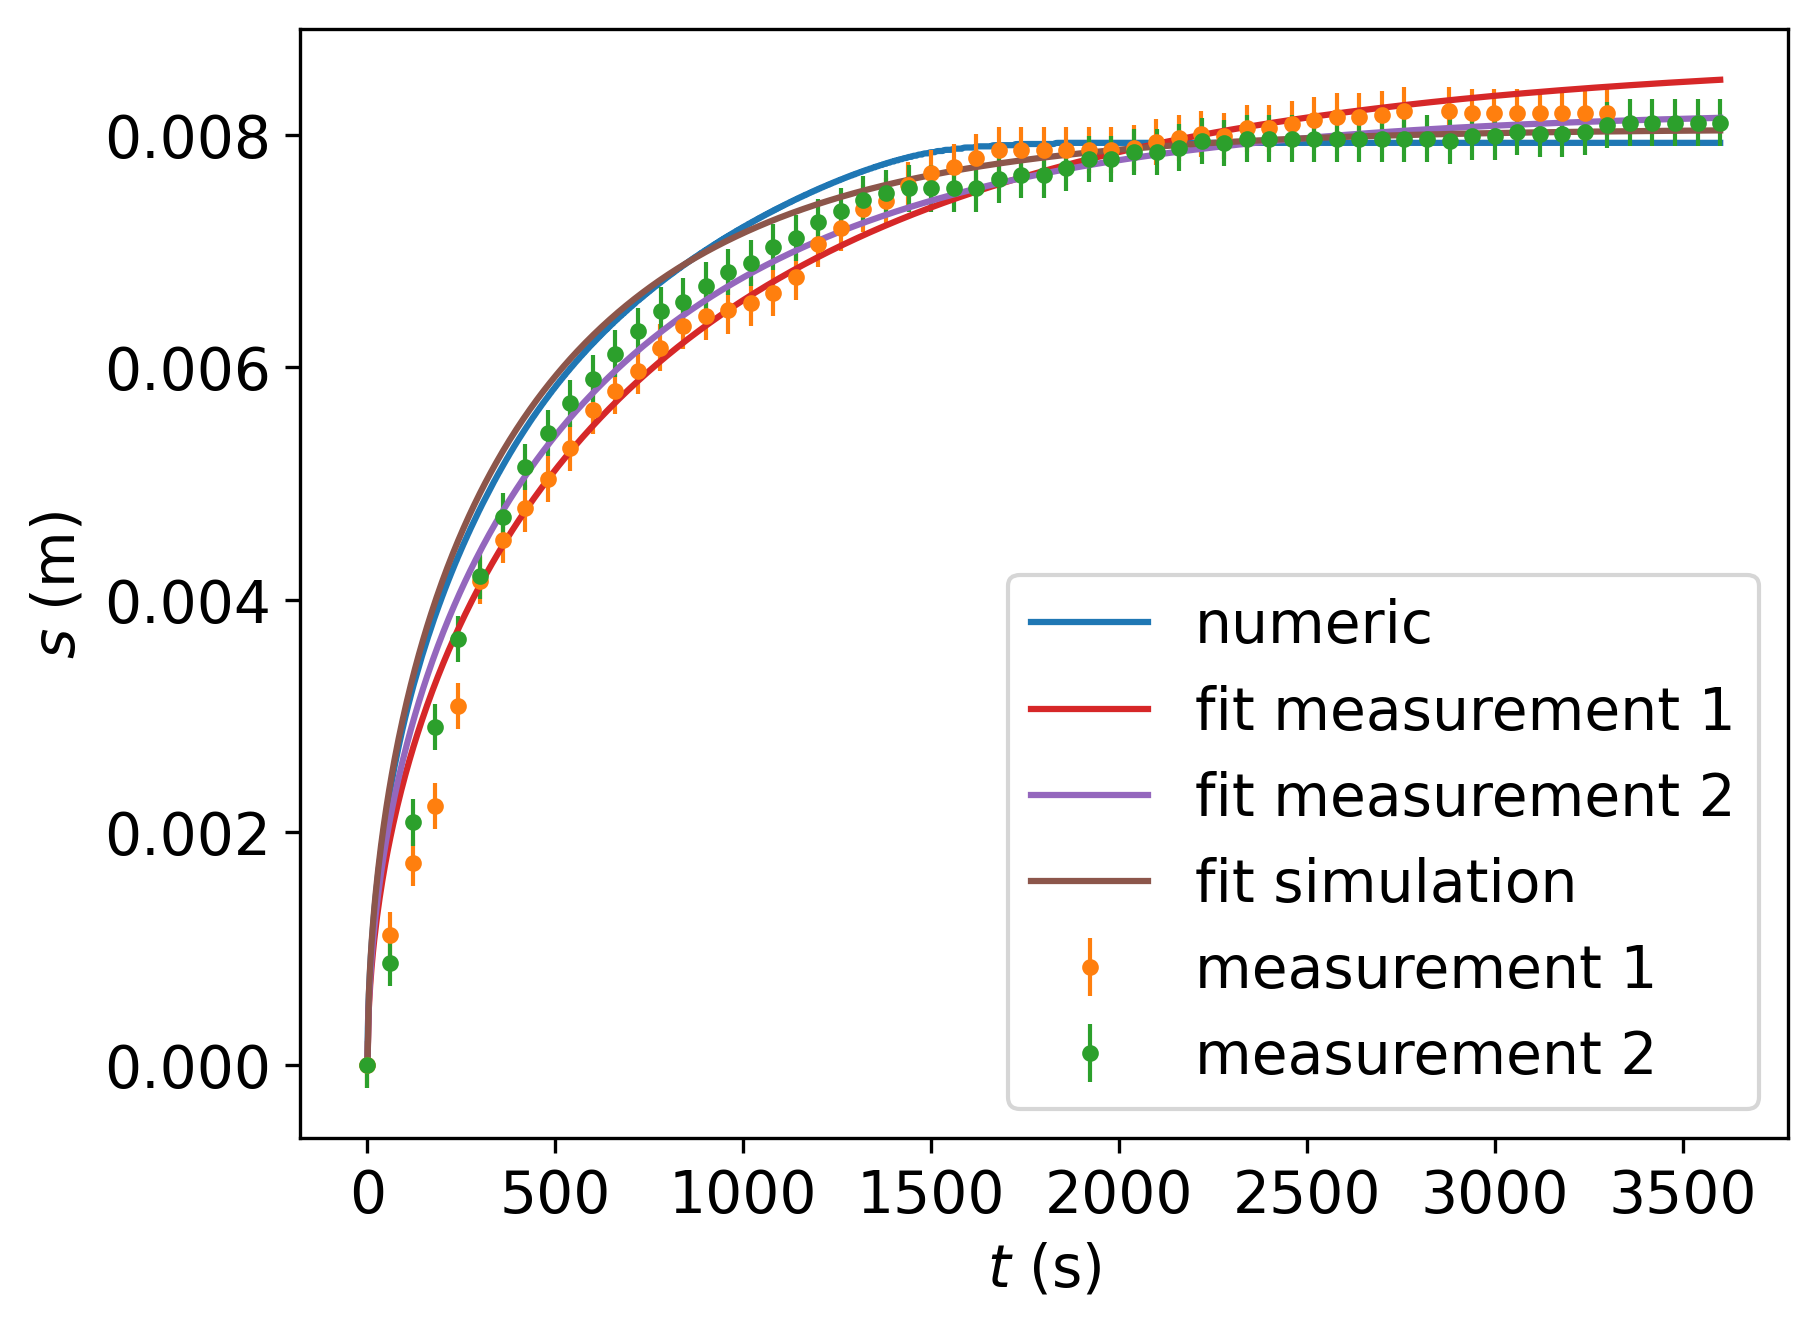

In [9]:
# T = np.loadtxt("returnsT0=120.0,dT=0.5,dx=4,dt=4_lossless.csv", delimiter=',')

T, dT, dx, dt = open_sim_file("results,T0=120.0,dT=0.05,dx=1.0e-05,dt=1.0e-05.csv")
x = np.arange(0, w, dx) # all cell positions
N = int(t1 / dt) # number of iterations for simulation time

fps = 1
t_fps = 1 / fps / dt # number of iterations between each frame
frames = np.where(np.arange(N, dtype=int) % int(t_fps) == 0)[0] # all iterations that are displayed

_, t_exp1, s_exp1 = np.loadtxt("VID2_20250702_121653112.csv", delimiter=',', skiprows=1).T
_, t_exp2, s_exp2 = np.loadtxt("VID2_20250702_141248613.csv", delimiter=',', skiprows=1).T

s_exp1 /= 1e3
s_exp2 /= 1e3

fit_func = lambda t, x_max, tau: x_max * np.sqrt(1 - np.exp(-t / tau))

popt1, popv1 = curve_fit(fit_func, t_exp1-min(t_exp1), s_exp1, p0=(0.008, 100))
errors1 = np.sqrt(np.diag(popv1))
popt2, popv2 = curve_fit(fit_func, t_exp2-min(t_exp2), s_exp2, p0=(0.008, 100))
errors2 = np.sqrt(np.diag(popv2))
t_fit = np.linspace(0, t1, 1000)

s = [x[np.abs(T[0] - Tm).argmin()]]
for i in range(1, len(frames)):
    index_min = np.abs(T[i] - Tm).argmin()
    if T[i][index_min] > Tm:
        s.append(x[index_min] + (Tm - T[i][index_min]) / (T[i][index_min + 1] - T[i][index_min]) * dx)
    if T[i][index_min] < Tm:
        s.append(x[index_min] - (Tm - T[i][index_min]) / (T[i][index_min - 1] - T[i][index_min]) * dx)


# s = [x[np.abs(T[i] - Tm).argmin()] for i in range(len(frames))]
t = frames * dt

# fit_func = lambda t, a, x_max: x_max * np.tanh(a * t)
popt, popv = curve_fit(fit_func, t, s, p0=(0.008, 100))
errors = np.sqrt(np.diag(popv))

plt.plot(t, s, label="numeric")
plt.errorbar(t_exp1[t_exp1 < t1 + min(t_exp1)] - min(t_exp1), s_exp1[t_exp1 < t1 + min(t_exp1)], yerr=0.0002, elinewidth=1, fmt='.', label="measurement 1")
plt.errorbar(t_exp2[t_exp2 < t1 + min(t_exp2)] - min(t_exp2), s_exp2[t_exp2 < t1 + min(t_exp2)], yerr=0.0002, elinewidth=1, fmt='.', label="measurement 2")
plt.plot(t_fit, fit_func(t_fit, *popt1), label="fit measurement 1")
plt.plot(t_fit, fit_func(t_fit, *popt2), label="fit measurement 2")
plt.plot(t_fit, fit_func(t_fit, *popt), label="fit simulation")
# plt.plot(t, 2 * k * np.sqrt(a_l * t), label="analytic")
plt.xlabel("$t$ (s)")
plt.ylabel("$s$ (m)")
plt.legend(loc="lower right")

print(f"simulation:\tx_max = {popt[0]} +/- {errors[0]}\ttau = {popt[1]} +/- {errors[1]}")
print(f"result 1:\tx_max = {popt1[0]} +/- {errors1[0]}\ttau = {popt1[1]} +/- {errors1[1]}")
print(f"result 2:\tx_max = {popt2[0]} +/- {errors2[0]}\ttau = {popt2[1]} +/- {errors2[1]}")

numeric: 0.4905012280795704 +/- 0.00017362297547224504
analytic: 0.4081365927393771


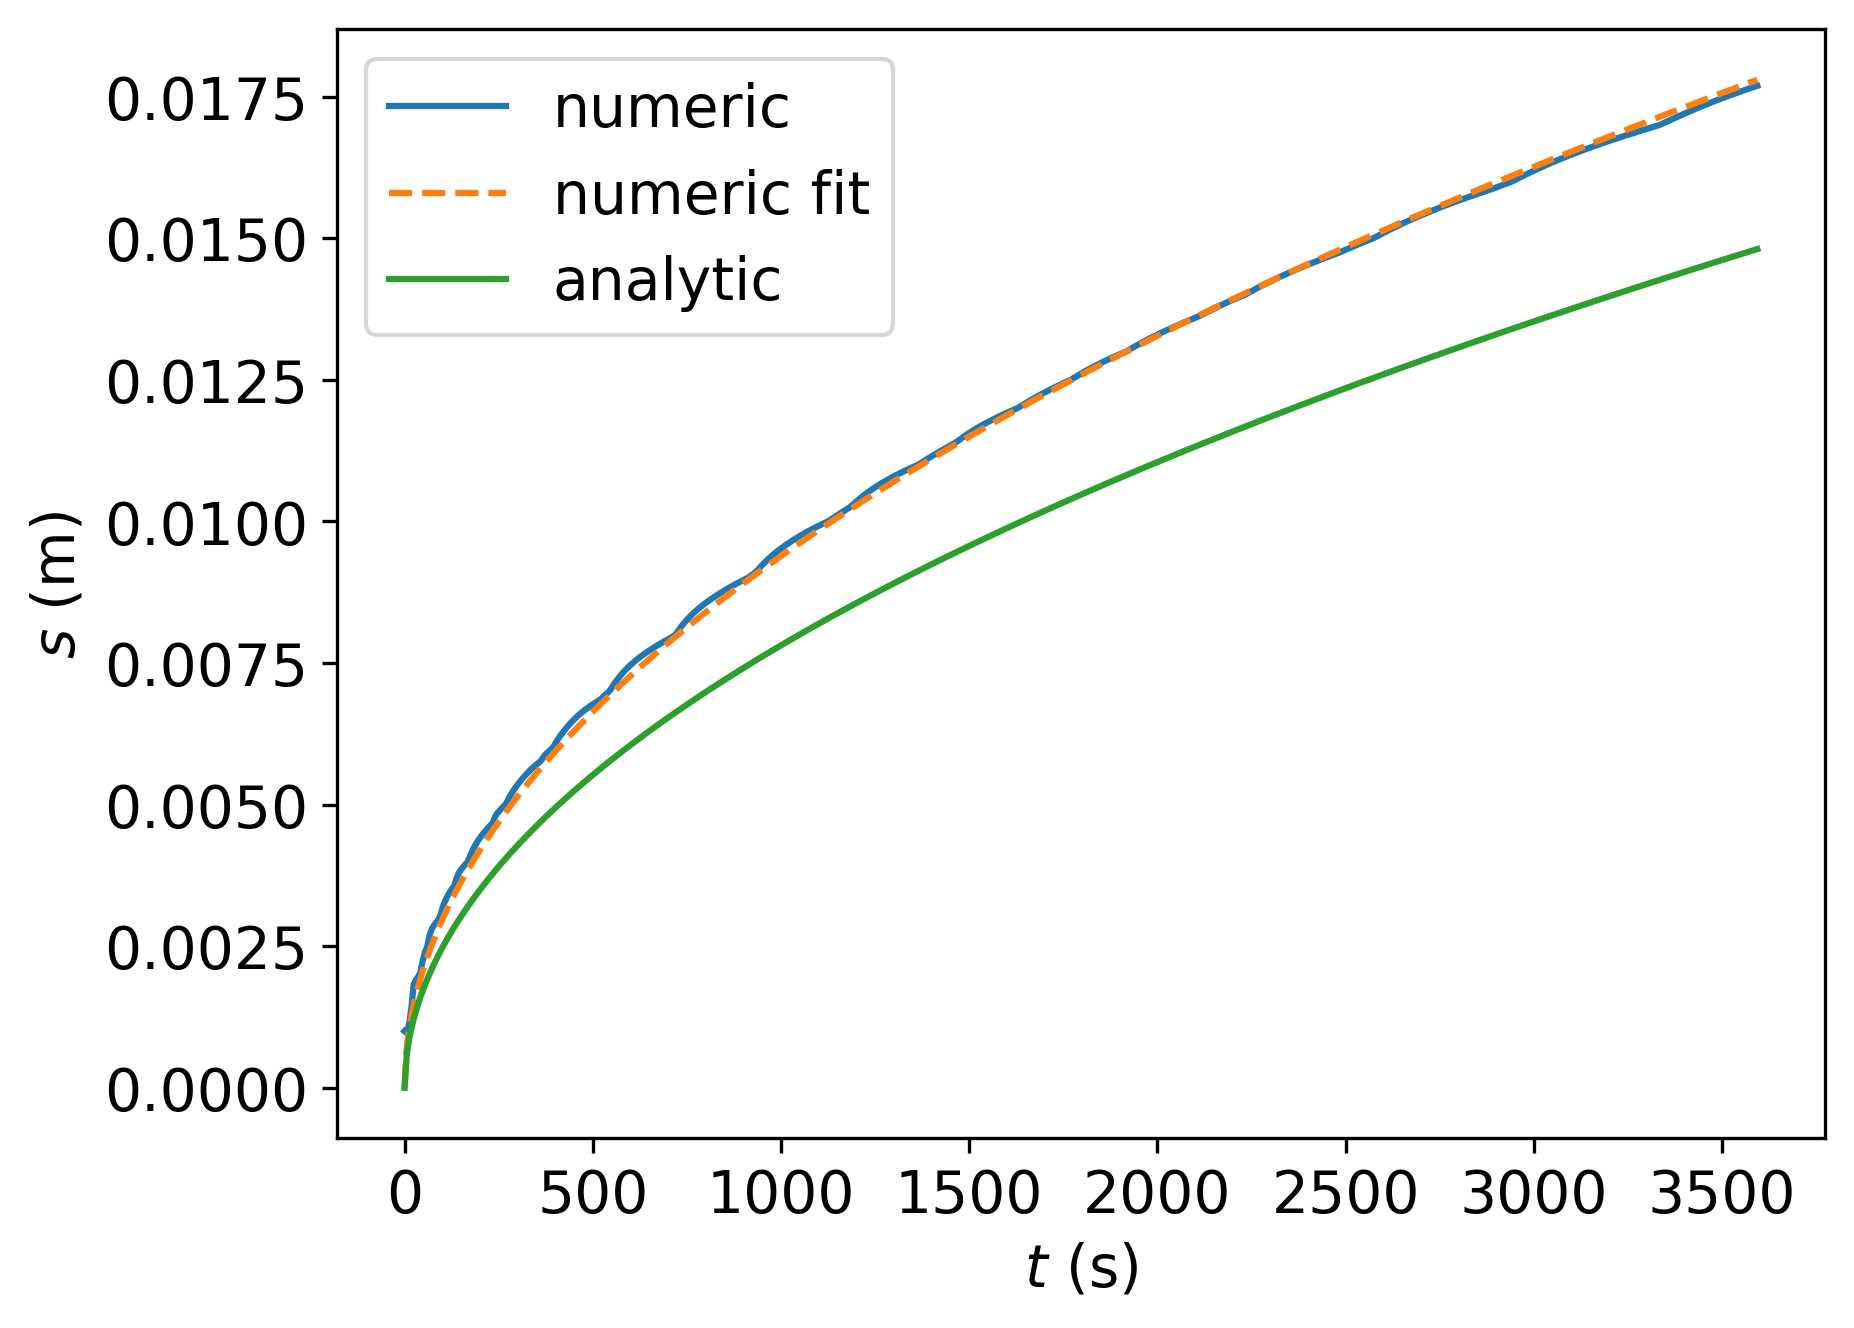

In [12]:
T, dT, dx, dt = open_sim_file("results,T0=120.0,dT=5.0,dx=1.0e-03,dt=1.0e-03.csv")

x = np.arange(0, w, dx) # all cell positions
N = int(t1 / dt) # number of iterations for simulation time

fps = 1/6
t_fps = 1 / fps / dt # number of iterations between each frame
frames = np.where(np.arange(N, dtype=int) % int(t_fps) == 0)[0] # all iterations that are displayed

_, t_exp1, s_exp1 = np.loadtxt("VID2_20250702_121653112.csv", delimiter=',', skiprows=1).T
_, t_exp2, s_exp2 = np.loadtxt("VID2_20250702_141248613.csv", delimiter=',', skiprows=1).T

s_exp1 /= 1e3
s_exp2 /= 1e3

s = [x[np.abs(T[0] - Tm).argmin()]]
for i in range(1, len(frames)):
    index_min = np.abs(T[i] - Tm).argmin()
    if T[i][index_min] > Tm:
        s.append(x[index_min] + (Tm - T[i][index_min]) / (T[i][index_min + 1] - T[i][index_min]) * dx)
    if T[i][index_min] < Tm:
        s.append(x[index_min] - (Tm - T[i][index_min]) / (T[i][index_min - 1] - T[i][index_min]) * dx)

# s = [x[np.abs(T[i] - Tm).argmin()] for i in range(len(frames))]
t = frames * dt

X_i = lambda t, k: 2 * k * np.sqrt(a_l * t)
popt, popv = curve_fit(X_i, t, s)
error = np.sqrt(np.diag(popv))
print(f"numeric: {popt[0]} +/- {error[0]}")
print(f"analytic: {k}")

t_fit = np.linspace(min(t), max(t), 1000)

plt.plot(t, s, label="numeric")
plt.plot(t_fit, X_i(t_fit, *popt), '--', label="numeric fit")
plt.plot(t, 2 * k * np.sqrt(a_l * t), label="analytic")
plt.xlabel("$t$ (s)")
plt.ylabel("$s$ (m)")
plt.legend(loc="upper left")

In [274]:
# the fraction of liquid in the mushy zone
def theta_l(T, dT):
    return (T - Tm + dT) / 2 / dT

# full_theta_l the total fraction liquid in all three zones
def full_theta_l(T, dT):
    # different zones
    mush_mask = (Tm - dT < T) & (T < Tm + dT)
    solid_mask = T <= Tm - dT
    liquid_mask = T >= Tm + dT

    theta = np.zeros_like(T)
    theta[solid_mask] = 0
    theta[liquid_mask] = 1
    theta[mush_mask] = theta_l(T[mush_mask], dT)
    return theta

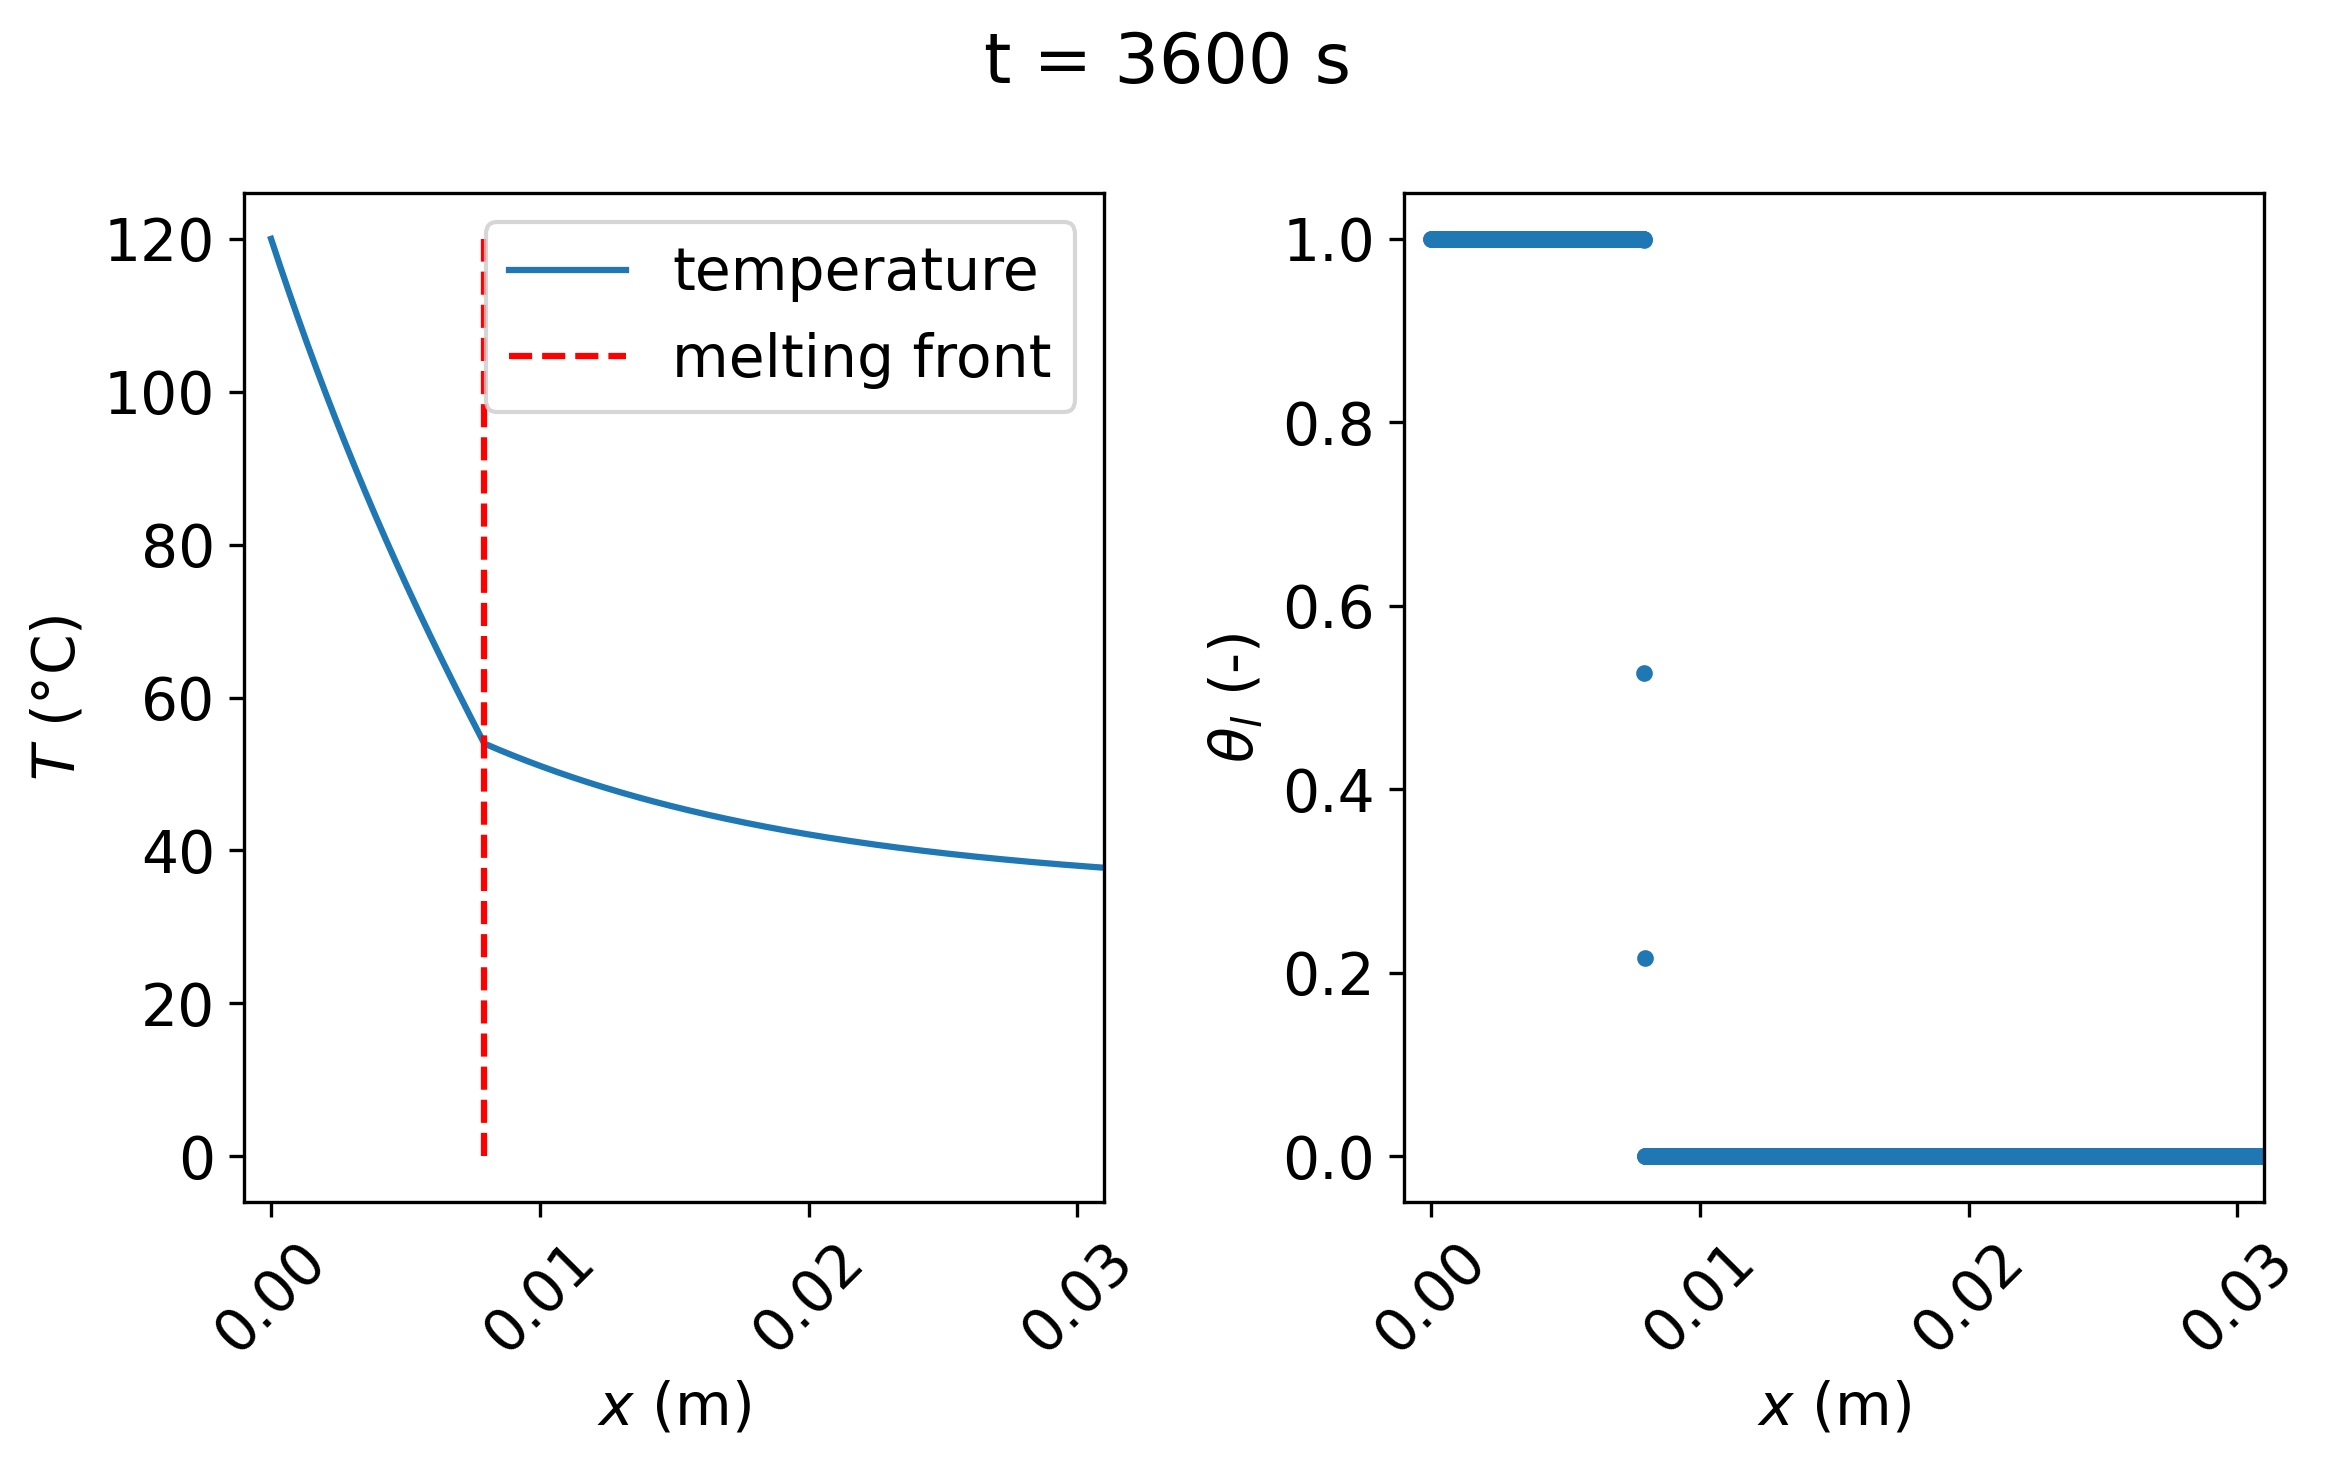

In [311]:
T, dT, dx, dt = open_sim_file("results,T0=120.0,dT=0.05,dx=1.0e-05,dt=1.0e-05.csv")

x = np.arange(0, w, dx) # all cell positions

t = 3600 # s

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ymin, ymax = 0, max(T[0])

ax[0].plot(x, T[t], label="temperature") # plot the temperature as a function of position
ax[1].plot(x, full_theta_l(T[t], dT), '.') # plot fraction of liquid on the right
ax[0].vlines(x[abs(T[t] - Tm).argmin()], ymin, ymax, "red", "dashed", label="melting front") # the position of the interface

title = fig.suptitle(f"t = {t} s")
ax[0].legend(loc="upper right")
ax[0].set_xlabel("$x$ (m)")
ax[0].set_ylabel("$T$ ($\\degree$C)")
ax[0].set_xticks(np.arange(0, 0.04, 0.01))
ax[0].tick_params('x', rotation=45)
ax[0].set_xlim(-0.001, 0.031)
ax[1].set_xlabel("$x$ (m)")
ax[1].set_ylabel("$\\theta_l$ (-)")
ax[1].set_xticks(np.arange(0, 0.04, 0.01))
ax[1].tick_params('x', rotation=45)
ax[1].set_xlim(-0.001, 0.031)
plt.tight_layout()